In [1]:
import os
import yaml

from lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, matthews_corrcoef, confusion_matrix, roc_auc_score
import torch
import torch_geometric
from torch_geometric.nn import global_max_pool
import umap


from virtual_screening import VirtualScreeningEmbedder, VirtualScreener, ClassicalVirtualScreener
from dataset import VirtualScreeningDataModule
from model import PharmacoMatch
from utils import load_model_from_path, enrichment_factor, bootstrap_metric, bedroc_score, PcaEmbeddingPlotter, UmapEmbeddingPlotter

umap.plot.output_notebook()

/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):


Loading BokehJS ...

In [2]:
# Define global variables
PROJECT_ROOT = '/data/shared/projects/PhectorDB'
PRETRAINING_ROOT = f"{PROJECT_ROOT}/training_data"
DATASET_ROOT = f"{PROJECT_ROOT}/DUD-E"
TARGET = "ADA"
VS_ROOT = f"{DATASET_ROOT}/{TARGET}"
#VS_ROOT='/data/local/drose/data/FA10'
MODEL = PharmacoMatch
VS_MODEL_NUMBER = 328
MODEL_PATH = f"{PROJECT_ROOT}/logs/{MODEL.__name__}/version_{VS_MODEL_NUMBER}/"
HPARAMS_FILE = "hparams.yaml"

params = yaml.load(
    open(os.path.join(PROJECT_ROOT, MODEL_PATH, HPARAMS_FILE), "r"), Loader=yaml.FullLoader
)

# Deterministic flags (should not be necessary for inference, but just in case)
torch.set_float32_matmul_precision("medium")
torch_geometric.seed_everything(params["seed"])
seed_everything(params["seed"])
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Setup datamodule
datamodule = VirtualScreeningDataModule(
    VS_ROOT,
    batch_size=512#params["batch_size"],
)
datamodule.setup()

# Load the model
model = load_model_from_path(os.path.join(PROJECT_ROOT, MODEL_PATH), MODEL)
trainer = Trainer(
    num_nodes=1,
    devices=[0],
    max_epochs=params["epochs"],
    accelerator="auto",
    logger=False,
    log_every_n_steps=2,
)

# Create embeddings of the VS dataset
embedder = VirtualScreeningEmbedder(model, datamodule, trainer)
screener = VirtualScreener(embedder)
classical_screener = ClassicalVirtualScreener(datamodule)

experiment_data = dict()
experiment_data['target'] = TARGET
experiment_data['model'] = VS_MODEL_NUMBER
experiment_data['embedding_time'] = screener.embedding_time
experiment_data['matching_time'] = screener.matching_time
experiment_data['query_num_features'] = datamodule.metadata.query['num_features'].sum()
experiment_data['active_ligands'] = torch.max(screener.active_mol_ids).item() + 1
experiment_data['inactive_ligands'] = torch.max(screener.inactive_mol_ids).item() + 1
experiment_data['active_conformations'] = len(screener.active_mol_ids)
experiment_data['inactive_conformations'] = len(screener.inactive_mol_ids)

Seed set to 42


Number of query graphs: 1
Number of active graphs: 2166
Number of inactive graphs: 125035


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
experiment_data

{'target': 'ADA',
 'model': 328,
 'embedding_time': 8.302759170532227,
 'matching_time': 0.02271723747253418,
 'query_num_features': 7,
 'active_ligands': 90,
 'inactive_ligands': 5448,
 'active_conformations': 2166,
 'inactive_conformations': 125035}

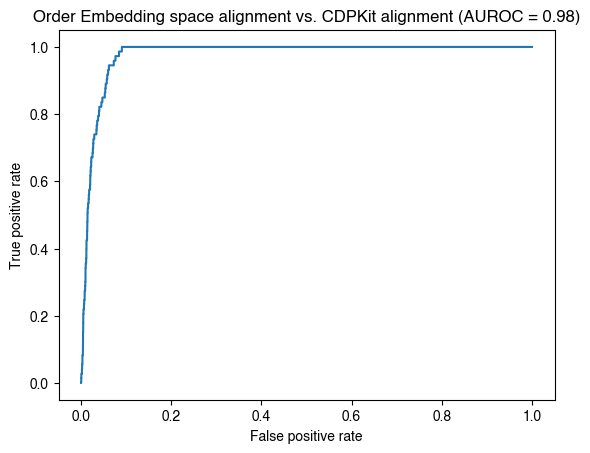

According to the ROC curve, the best threshold is 6506.98486328125.
----------------------------
This yields an MCC of 0.07573699570919723.
AUROC = 0.9768955762846722.
Confusion matrix:
[[115626  11502]
 [     0     73]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.16734201720495206.
Confusion matrix:
[[4513  990]
 [   0   35]]


In [4]:
# Determine optimal threshold via ROC curve
y_true = classical_screener.matches
y_pred = -screener.conformation_score
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc = roc_auc_score(y_true, y_pred)
j = tpr - fpr
idx = np.argmax(j)
best_threshold = -threshold[idx]
y_pred = screener.conformation_score <= best_threshold

plt.plot(fpr, tpr)
plt.title(f"Order Embedding space alignment vs. CDPKit alignment (AUROC = {auroc:.2f})")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()
        
print(f"According to the ROC curve, the best threshold is {best_threshold}.")
print("----------------------------")
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print(f"AUROC = {auroc}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("----------------------------")
print("Aggregation of conformational ensembles into one result per molecule:")
y_true = global_max_pool(y_true, screener.mol_ids)
y_pred = global_max_pool(y_pred, screener.mol_ids)
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

experiment_data['auroc_comparison'] = auroc

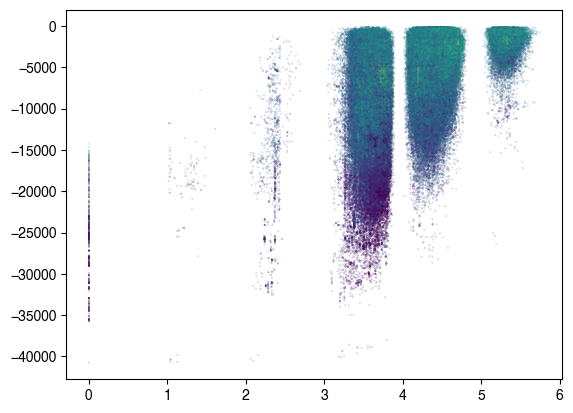

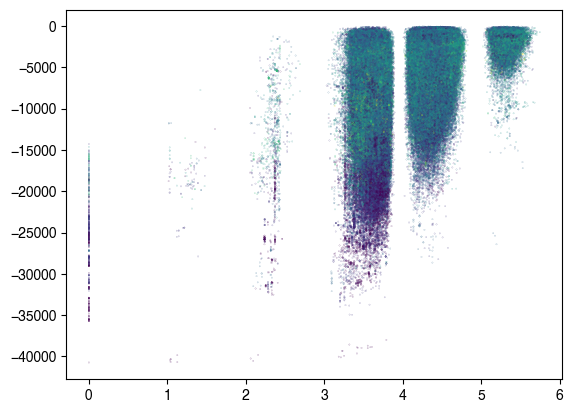

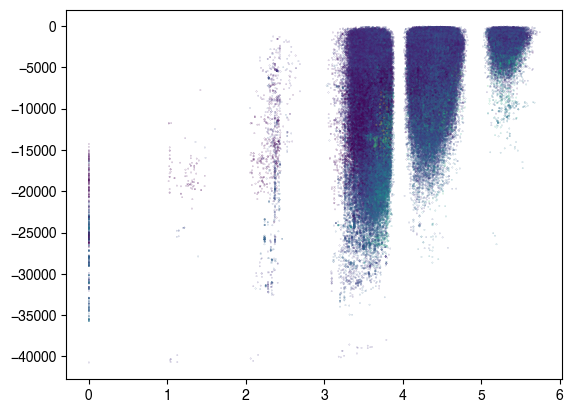

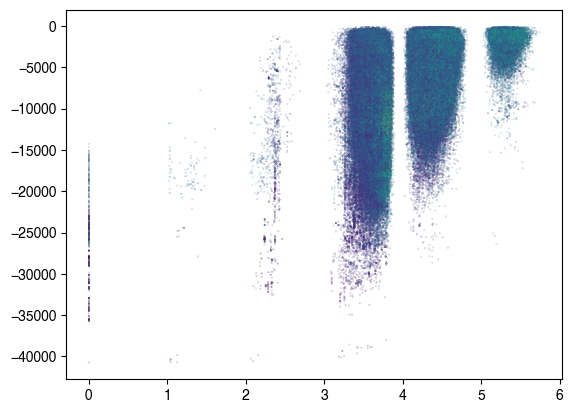

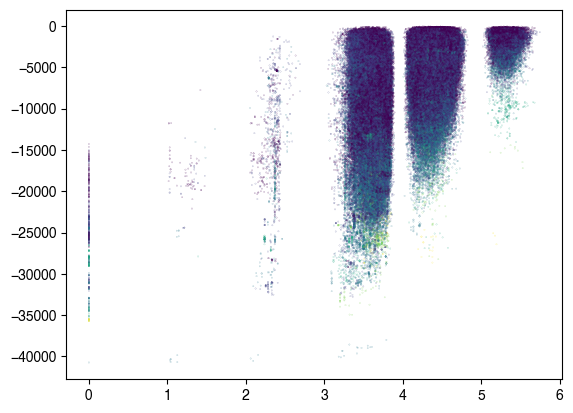

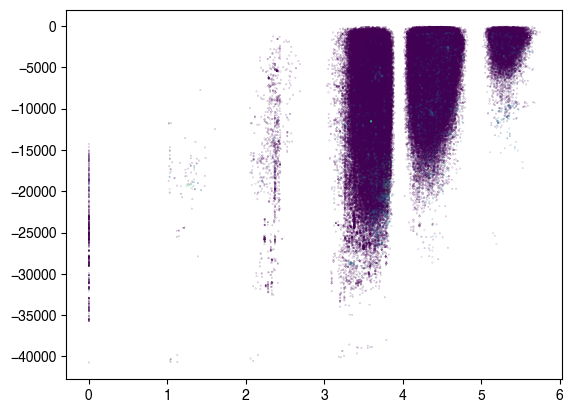

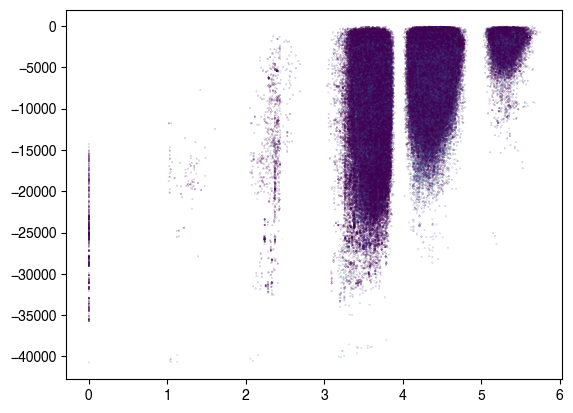

In [8]:
import pandas as pd
import re

def get_feature_count(feature, metadata):
    feature_count = []
    count = 0
    for feature_string in metadata["features"]:
        if f"{feature}(" in feature_string:
            for str in feature_string.split(","):
                if f"{feature}(" in str:
                    count = int(re.findall(r"\d+", str)[0])
        else:
            count = 0
        feature_count.append(count)

    return feature_count
    
metadata = pd.concat(
    (
        datamodule.metadata.active,
        datamodule.metadata.inactive,

    ),
    ignore_index=True,
)
features = {
    "H": "Hydrophobic",
    "AR": "Aromatic",
    "HBD": "Hydrogen Bond Donor",
    "HBA": "Hydrogen Bond Acceptor",
    "PI": "Positive Ionizable",
    "NI": "Negative Ionizable",
    "XBD": "Halogen Bond Donor",
}

for feature in features.keys():
    feature_count = get_feature_count(feature, metadata)
    plt.scatter(classical_screener.alignment_score, -screener.conformation_score, s=0.01, c=feature_count)
    plt.show()

In [9]:
# bootrstrapping
y_true = classical_screener.matches
y_pred = -screener.conformation_score
auroc_mean, auroc_std = bootstrap_metric(y_true, y_pred, roc_auc_score, 1000)
print(f"Bootstrapped AUROC: {auroc_mean:.2f} ± {auroc_std:.2f}")

KeyboardInterrupt: 

In [7]:
# Feature Count baseline - We need to get better than this
print("--- Feature count baseline for inactive ligands ---")
y_true = classical_screener.matches
y_pred = screener.prefilter_mask
print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nAfter aggregation of the conformational ensembles:")
y_true = global_max_pool(y_true, screener.mol_ids)
y_pred = global_max_pool(y_pred, screener.mol_ids)
print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

--- Feature count baseline for inactive ligands ---
MCC: 0.08382311948383199
Confusion matrix:
[[281144 291544]
 [    61   4421]]

After aggregation of the conformational ensembles:
MCC: 0.1882472975652613
Confusion matrix:
[[13373 12287]
 [   23   966]]


In [8]:
# We can also combine the prefilter with the order embedding alignment
y_true = classical_screener.matches
y_pred = -screener.conformation_score
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc = roc_auc_score(y_true, y_pred)
j = tpr - fpr
idx = np.argmax(j)
best_threshold = -threshold[idx]
y_pred = screener.conformation_score <= best_threshold
y_pred = y_pred * screener.prefilter_mask 

print(f"According to the ROC curve, the best threshold is {best_threshold}.")
print("----------------------------")
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print(f"AUROC = {auroc}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("----------------------------")
print("Aggregation of conformational ensembles into one result per molecule:")
y_true = global_max_pool(y_true, screener.mol_ids)
y_pred = global_max_pool(y_pred, screener.mol_ids)
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

According to the ROC curve, the best threshold is 8070.98876953125.
----------------------------
This yields an MCC of 0.14854804593861298.
AUROC = 0.9067918578425929.
Confusion matrix:
[[463431 109257]
 [   616   3866]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.2650202275195586.
Confusion matrix:
[[19439  6221]
 [  137   852]]


Bootstrapped AUROC: 0.80 ± 0.03
Bootstrapped BEDROC: 0.39 ± 0.04
The enrichment factor at 0.005 is 6.6666669845581055.
The enrichment factor at 0.01 is 10.0.
The enrichment factor at 0.05 is 8.88888931274414.
----------------------------
Bootstrapped AUROC: 0.94 ± 0.02
Bootstrapped BEDROC: 0.79 ± 0.04
The enrichment factor at 0.005 is 60.0.
The enrichment factor at 0.01 is 53.333335876464844.
The enrichment factor at 0.05 is 16.22222137451172.
----------------------------


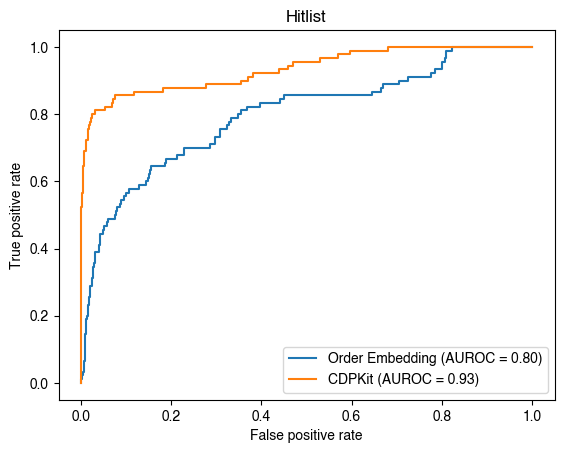

In [5]:
# Hitlist with the order embedding algorithm
y_true = screener.ligand_label
y_pred = -screener.ligand_score
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc = roc_auc_score(y_true, y_pred)
bedroc = bedroc_score(y_true, y_pred)
experiment_data['order_embedding_auroc'] = auroc

auroc_mean, auroc_std = bootstrap_metric(y_true, y_pred, roc_auc_score, 50)
print(f"Bootstrapped AUROC: {auroc_mean:.2f} ± {auroc_std:.2f}")
bedroc_mean, bedroc_std = bootstrap_metric(y_true, y_pred, bedroc_score, 50)
print(f"Bootstrapped BEDROC: {bedroc_mean:.2f} ± {bedroc_std:.2f}")

fig = plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
alphas = [0.005, 0.01, 0.05]
for alpha in alphas:    
    enrichment = enrichment_factor(y_true, y_pred, alpha).item()
    print(f"The enrichment factor at {alpha} is {enrichment}.")
    experiment_data[f'order_embedding_ef{alpha}'] = enrichment
print("----------------------------")

# Hitlist with the CDPKit alignment
y_true = screener.ligand_label
y_pred = global_max_pool(classical_screener.alignment_score, screener.mol_ids)

#path="matching.png"  
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc_cdp = roc_auc_score(y_true, y_pred)
bedroc_cdp = bedroc_score(y_true, y_pred)
experiment_data['cdpkit_auroc'] = auroc_cdp

auroc_mean, auroc_std = bootstrap_metric(y_true, y_pred, roc_auc_score, 50)
print(f"Bootstrapped AUROC: {auroc_mean:.2f} ± {auroc_std:.2f}")
bedroc_mean, bedroc_std = bootstrap_metric(y_true, y_pred, bedroc_score, 50)
print(f"Bootstrapped BEDROC: {bedroc_mean:.2f} ± {bedroc_std:.2f}")

plt.plot(fpr, tpr)
plt.title(f"Hitlist")
plt.legend([f"Order Embedding (AUROC = {auroc:.2f})", f"CDPKit (AUROC = {auroc_cdp:.2f})"])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

alphas = [0.005, 0.01, 0.05]
for alpha in alphas:    
    enrichment = enrichment_factor(y_true, y_pred, alpha).item()
    print(f"The enrichment factor at {alpha} is {enrichment}.")
    experiment_data[f'cdpkit_ef{alpha}'] = enrichment
print("----------------------------")

plt.show()

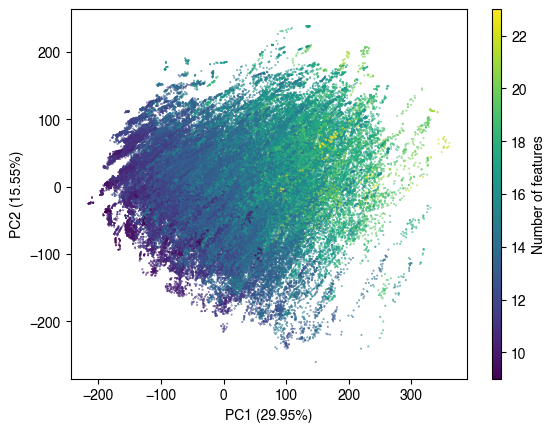

In [6]:
pca_plotter = PcaEmbeddingPlotter(screener, datamodule.metadata)
fig3 = pca_plotter.create_pca_plot()
fig3.show()

In [7]:
def get_highest_scoring_conformations(screener, num_conformations):
    vals, idx = torch.topk(-screener.conformation_score, num_conformations)
    set(screener.mol_ids[idx].tolist())

    mapping = dict()

    for val, id in zip(vals, idx):
        if screener.mol_ids[id].item() in mapping.keys():
            mapping[screener.mol_ids[id].item()].append((val.item(), id.item()))
        else:
            mapping[screener.mol_ids[id].item()] = [(val.item(), id.item())]
        
    mol_idx = [key for key in mapping.keys()]
    conf_idx = [val[0][1] for val in mapping.values()]
    
    return mol_idx, conf_idx

get_highest_scoring_conformations(screener, 30)

([4585, 1336, 5076, 4593], [104247, 30478, 116141, 104444])

In [8]:
from sklearn.decomposition import PCA


active_counts = datamodule.metadata.active["num_features"].values
inactive_counts = datamodule.metadata.inactive["num_features"].values
counts = np.concatenate((active_counts, inactive_counts))

pca = PCA(n_components=4)
transformed = torch.cat((screener.active_embeddings, screener.inactive_embeddings))
pca.fit(transformed)
variance = pca.explained_variance_ratio_
transformed = pca.transform(transformed)
query_transformed = screener.query_embedding
query_transformed = pca.transform(screener.query_embedding)
mol_idx, conf_idx = get_highest_scoring_conformations(screener, 300)

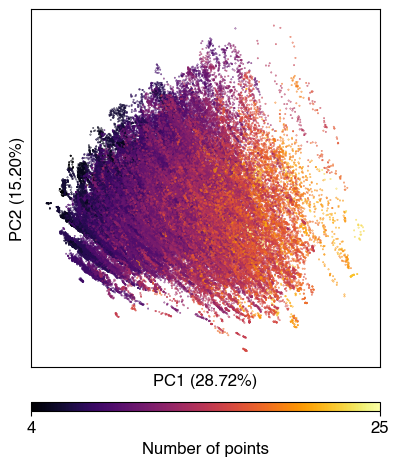

In [33]:
fig = plt.figure(figsize=(4.5, 6), frameon=False)
plt.scatter(
    transformed[:, 0],
    transformed[:, 1],
    c=counts,
    cmap="inferno",
    s=0.1,
)
fontsize=12
cbar = plt.colorbar(aspect=40, ticks=[min(counts), max(counts)], orientation="horizontal", pad=0.075, spacing="uniform")
cbar.set_label("Number of points", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
# plt.scatter(
#     transformed[:, 0][conf_idx],
#     transformed[:, 1][conf_idx],
#     c='red',
#     s=10,
# )
# plt.scatter(
#     query_transformed[:, 0],
#     query_transformed[:, 1],
#     c='yellow',
#     marker='*',
#     s=100,
# )
plt.xlabel(f"PC1 ({variance[0]*100:.2f}%)", fontsize=fontsize)
plt.ylabel(f"PC2 ({variance[1]*100:.2f}%)", fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.savefig("pca.jpg", dpi=300)

In [63]:
num_active_mols = len(screener.active_ligand_score)
num_active_confs = len(screener.active_conformation_score)
print(f"Number of active molecules: {num_active_mols}")
print(f"Number of active conformations: {num_active_confs}")

mol_idxes = (np.array(mol_idx) - num_active_mols).tolist()
conf_idxes = (np.array(conf_idx) - num_active_confs).tolist()

Number of active molecules: 90
Number of active conformations: 2166


In [74]:
db_accessor.getConformationIndex(25)

0

In [9]:
import CDPL.Pharm as Pharm
import CDPL.Chem as Chem
import sys

path = f"{VS_ROOT}/raw/inactives.psd"
db_accessor = Pharm.PSDScreeningDBAccessor(path)
mol = Chem.BasicMolecule()
ph4 = Pharm.BasicPharmacophore()
mol_writer = Chem.MolecularGraphWriter("molecules.sdf")
ph4_writer = Pharm.FeatureContainerWriter("pharmacophores.pml")

num_molecules = db_accessor.getNumMolecules()

for mol_id, conf_id in zip(mol_idxes, conf_idxes):
    try:
        num_pharmacophores = db_accessor.getNumPharmacophores(mol_id)
        db_accessor.getPharmacophore(conf_id, ph4)
        db_accessor.getMolecule(mol_id, mol)
        conf = db_accessor.getConformationIndex(conf_id)
        name = Chem.getName(mol).strip()
        print(name, conf)
        mol_writer.write(mol)
        ph4_writer.write(ph4)


    except Exception as e:
        sys.exit("Error: processing of pharmacophore failed: " + str(e))

mol_writer.close()
ph4_writer.close()


NameError: name 'mol_idxes' is not defined

In [34]:
umap_plotter = UmapEmbeddingPlotter(screener, datamodule.metadata)

In [35]:
fig4 = umap_plotter.create_umap_plot()
fig4.show()
fig4.savefig("umap.jpg", dpi=300)

In [10]:
p = umap_plotter.create_interactive_umap_by_feature_type("HBD")
umap.plot.show(p)